In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"xxxalifixa","key":"ce2ff84ca7ca2622534c0ea145403d61"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!ls ~/.kaggle

kaggle.json


In [7]:
!kaggle datasets download -d madisona/translated-animals10

 97% 571M/586M [00:03<00:00, 185MB/s]
100% 586M/586M [00:03<00:00, 170MB/s]


In [8]:
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

animals10


In [9]:
!ls animals/animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [10]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import zipfile, os
import warnings
warnings.filterwarnings("ignore")

In [11]:
import shutil
import os

hewan = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(hewan))


['squirrel', 'sheep', 'horse', 'butterfly', 'cat', 'cow', 'spider', 'dog', 'chicken', 'elephant']


In [12]:
hewan_bye = ['cat', 'cow', 'elephant', 'horse', 'sheep', 'squirrel']

for x in hewan_bye:
  path = os.path.join(hewan, x)
  shutil.rmtree(path)

In [13]:
hewanku = os.listdir(hewan)
print(hewanku)

['butterfly', 'spider', 'dog', 'chicken']


In [14]:
for animal in hewanku:
    print(f'{animal} images: ', len(os.listdir(f'/content/animals/animals10/raw-img/{animal}')))

butterfly images:  2112
spider images:  4821
dog images:  4863
chicken images:  3098


<function matplotlib.pyplot.show>

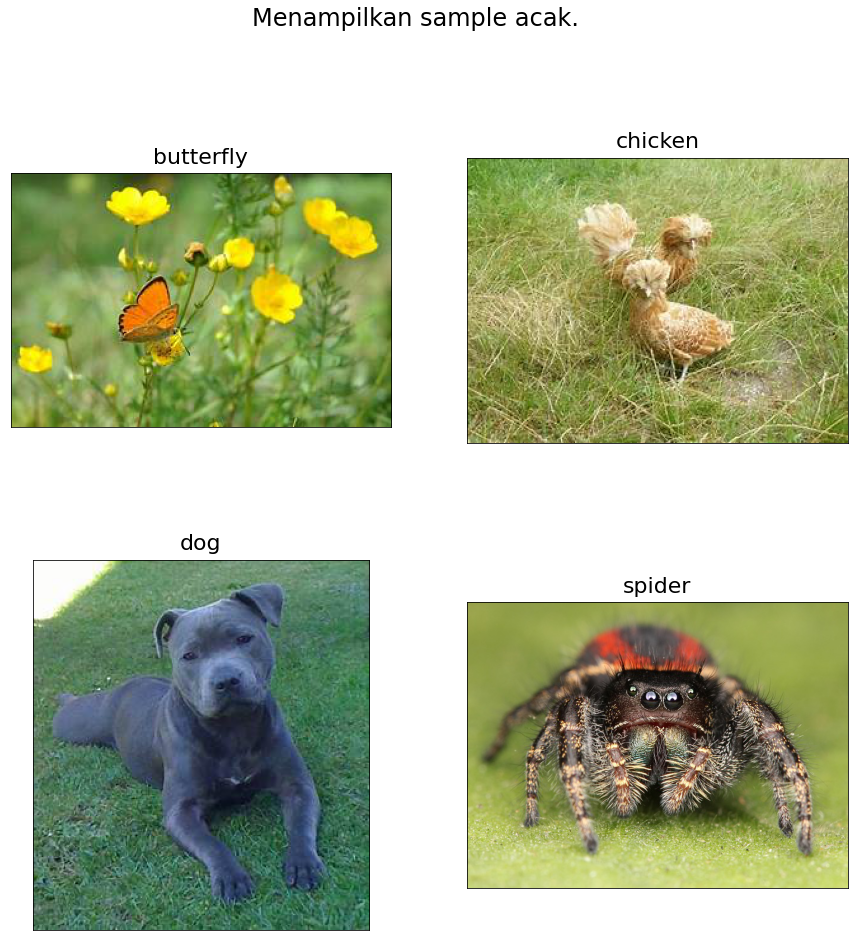

In [15]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Menampilkan sample acak.", fontsize=24)
hewan_sort = sorted(hewanku)
hewan_id = 0
for i in range(2):
  for j in range(2):
    try:
      hewan_pilih = hewan_sort[hewan_id] 
      hewan_id += 1
    except:
      break
    if hewan_pilih == '.TEMP':
        continue
    hewan_pilih_gambar = os.listdir(os.path.join(hewan, hewan_pilih))
    hewan_pilih_acak= np.random.choice(hewan_pilih_gambar)
    img = plt.imread(os.path.join(hewan, hewan_pilih, hewan_pilih_acak))
    ax[i][j].imshow(img)
    ax[i][j].set_title(hewan_pilih, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [16]:
try:
  os.mkdir('/content/animals/animals10/training')
  os.mkdir('/content/animals/animals10/testing')
  for hewanku in hewanku:
    os.mkdir(f'/content/animals/animals10/training/{hewanku}')
    os.mkdir(f'/content/animals/animals10/testing/{hewanku}')
except OSError:
  pass

In [17]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)

split_size = 0.8 # 80% Data Training and 20% Data Validation

butterfly_images_path = "/content/animals/animals10/raw-img/butterfly/"
butterfly_train_path = "/content/animals/animals10/training/butterfly/"
butterfly_test_path = "/content/animals/animals10/testing/butterfly/"
split_data(butterfly_images_path, butterfly_train_path, butterfly_test_path, split_size)

chicken_images_path = "/content/animals/animals10/raw-img/chicken/"
chicken_train_path = "/content/animals/animals10/training/chicken/"
chicken_test_path = "/content/animals/animals10/testing/chicken/"
split_data(chicken_images_path, chicken_train_path, chicken_test_path, split_size)

dog_images_path = "/content/animals/animals10/raw-img/dog/"
dog_train_path = "/content/animals/animals10/training/dog/"
dog_test_path = "/content/animals/animals10/testing/dog/"
split_data(dog_images_path, dog_train_path, dog_test_path, split_size)

spider_images_path = "/content/animals/animals10/raw-img/spider/"
spider_train_path = "/content/animals/animals10/training/spider/"
spider_test_path = "/content/animals/animals10/testing/spider/"
split_data(spider_images_path, spider_train_path, spider_test_path, split_size)


In [18]:
total_train = len(os.listdir(butterfly_train_path)) + len(os.listdir(chicken_train_path)) + \
              len(os.listdir(dog_train_path)) + len(os.listdir(spider_train_path)) 
total_test  = len(os.listdir(butterfly_test_path)) + len(os.listdir(chicken_test_path)) + \
              len(os.listdir(dog_test_path)) + len(os.listdir(spider_test_path)) 

print("Total data training " + str(total_train) + " baris dan data validasi " + str(total_test))

Total data training 11913 baris dan data validasi 2981


In [19]:
batch_size = 64
TRAINING_DIR = '/content/animals/animals10/training'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, 
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150,150)
)

VALIDATION_DIR = "/content/animals/animals10/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 11913 images belonging to 4 classes.
Found 2981 images belonging to 4 classes.


In [20]:
reduceku = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5, 
    min_lr=1.5e-5
)

stopku = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True
)


In [21]:
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.subplot(1, 2, 1)
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.subplot(1, 2, 2)
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plt.figure(figsize=(15,5))
  plot_acc(history)
  plot_loss(history)


In [22]:
tf.keras.backend.clear_session()

modelku = tf.keras.models.Sequential([
    InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

modelku.layers[0].trainable = False

modelku.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1179712   
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 22,983,604
Trainable params: 1,180,820
Non-

In [23]:
modelku.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

historyku = modelku.fit(
    train_generator,
    epochs=5,
    callbacks = [reduceku, stopku],
    verbose=1,
    validation_data=validation_generator
)

Epoch 1/5
187/187 [==============================] - 576s 3s/step - loss: 0.4082 - accuracy: 0.8926 - val_loss: 0.1552 - val_accuracy: 0.9527
Epoch 2/5
187/187 [==============================] - 568s 3s/step - loss: 0.2043 - accuracy: 0.9357 - val_loss: 0.1020 - val_accuracy: 0.9668
Epoch 3/5
187/187 [==============================] - 569s 3s/step - loss: 0.1916 - accuracy: 0.9413 - val_loss: 0.1223 - val_accuracy: 0.9641
Epoch 4/5
187/187 [==============================] - 569s 3s/step - loss: 0.1686 - accuracy: 0.9460 - val_loss: 0.1212 - val_accuracy: 0.9618
Epoch 5/5
187/187 [==============================] - 569s 3s/step - loss: 0.1719 - accuracy: 0.9467 - val_loss: 0.1063 - val_accuracy: 0.9675


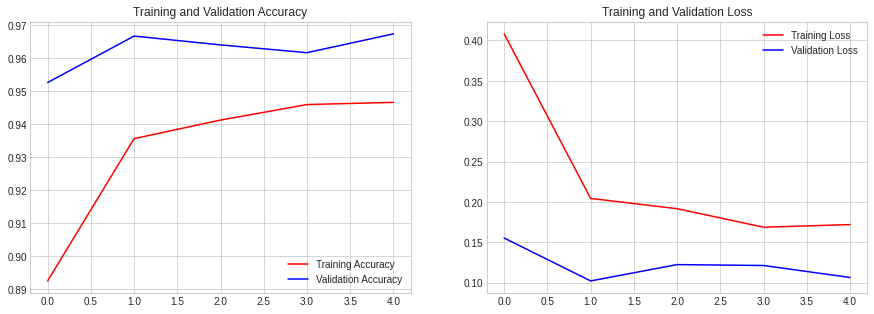

In [24]:
plot_history(historyku)

In [25]:
modelku.save_weights('modelkuweights.h5')
modelku.save('modelku.h5')

In [27]:
konvert = tf.lite.TFLiteConverter.from_keras_model(modelku)
tflite_modelku = konvert.convert()

with tf.io.gfile.GFile('modelku.tflite', 'wb') as f:
  f.write(tflite_modelku)

INFO:tensorflow:Assets written to: /tmp/tmpgqt7deph/assets


In [34]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=159,
    class_mode='categorical',
    target_size=(150, 150),
    shuffle = False
)
filenames = validation_generator.filenames
nb_ku = len(filenames)

Y_pred = modelku.predict_generator(validation_generator, steps = nb_ku)
y_pred = np.argmax(Y_pred, axis=1)

file_names = ['butterfly','chicken','dog','spider']
print(classification_report(validation_generator.classes, y_pred, target_names=file_names))

Found 2981 images belonging to 4 classes.


              precision    recall  f1-score   support

   butterfly       0.89      0.97      0.93       423
     chicken       0.97      0.96      0.97       620
         dog       0.99      0.97      0.98       973
      spider       0.98      0.97      0.98       965

    accuracy                           0.97      2981
   macro avg       0.96      0.97      0.96      2981
weighted avg       0.97      0.97      0.97      2981

